# LSTM
Added F1 score and ran a full model through cross-validation.

In [85]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-12 23:48:39.234510
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [86]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCELLS=64
EPOCHS=10
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=4000   # this is problematic as some genes will be excluded entirely or partially

In [87]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [88]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [89]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [90]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-12-12 23:48:40.891464
Num RCI: 13000
[('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]


In [91]:
def seq_to_kmers(rna,K):
    VALS = {'A':0, 'C':1, 'G':2, 'T':3}
    length = len(rna)
    vec=[]
    for i in range(length-K+1):
        value = 0
        for j in range(K):
            value *= 4   
            nextnuc = rna[i+j] # to do: avoid recomputing k-1 bases next time
            if nextnuc=='N':
                value = -1   # indicate an N
                break
            nucval = VALS[nextnuc]
            value += nucval
        value += 1   # NNN => 0, AAA => 1
        vec.append(value)
    return vec
print(seq_to_kmers('AAAA',3))
print(seq_to_kmers('CATT',3))
print(seq_to_kmers('TTGA',3))
print(seq_to_kmers('TTTN',3))

[1, 1]
[20, 16]
[63, 57]
[64, 0]


In [92]:
print(datetime.now())
print('Load sequence')
filepath = DATA_DIR+SEQUENCE_FILE
labels=[]
allids=[]
allseq=[]
NREPEAT = str('N'*MAXLEN)
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            tran_id = fields[0]  # with version number
            gene_id = fields[1]        # without version number
            seq_len = int(fields[3])
            seq_txt = fields[4]
            if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                if seq_len<MAXLEN:
                    seq_txt = seq_txt + NREPEAT
                    seq_txt = seq_txt[:MAXLEN]
                hot_vec = seq_to_kmers(seq_txt,K)
                allseq.append(hot_vec)
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
#print('Example:',allseq[3])

2022-12-12 23:48:40.952028
Load sequence
2022-12-12 23:50:17.072423
Num IDs: 31220
Num labels: 31220
Num counts: 31220


In [93]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    subsetX = np.array(subsetX)
    subsetY = np.array(subsetY).reshape((-1,1))
    return subsetX,subsetY

In [94]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    # To do: try with and without masking layer
    # To do: try the embedding layer with mask, instead of masking layer
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, K))
    #mask_layer = Masking(mask_value=0, input_shape=(ADJUST_LENGTH, 1))
    # This layer automatically converts inputs to one-hot using alphabet size.
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    # rnn1_layer = LSTM(16, return_sequences=True, input_shape=[MAXLEN,DIMEN]) 
    rnn1_layer = LSTM(RCELLS, return_sequences=False) # True)
    # rnn1_layer = Bidirectional( LSTM(32, return_sequences=True) )
    # rnn1_layer = LSTM(16, return_sequences=True) 
    # rnn2_layer = LSTM(16, return_sequences=True)
    # Dense can handle sequence input. Is it the best thing to do?
    dense1_layer = Dense(16,activation='sigmoid',dtype=dt)
    dropout1_layer = Dropout(0.25)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    #rnn.add(rnn2_layer)
    rnn.add(dense1_layer)
    rnn.add(dropout1_layer)
    #rnn.add(dense2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [95]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-12 23:50:17.110819
COMPILE
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 3997, 4)           1028      
                                                                 
 lstm_19 (LSTM)              (None, 64)                17664     
                                                                 
 dense_21 (Dense)            (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 19,749
Trainable params: 19,749
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
def do_cross_validation(eps):
    cv_accuracy=[]
    cv_precision=[]
    cv_recall=[]
    cv_f1=[]
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        fold += 1
        print('Fold',fold)
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,allseq,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,allseq,labels,0)

        print('Training example')
        print(X_train[0])
        
        print('Train sizes',X_train.shape,y_train.shape)
        print('Valid sizes',X_valid.shape,y_valid.shape)
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        yhat_pred=model.predict(X_valid, verbose=0) 
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        THRESHOLD=0.5
        yhat_classes=np.where(yhat_pred > THRESHOLD, 1, 0)
        print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
        # accuracy: (tp + tn) / (p + n)
        accuracy = accuracy_score(y_valid, yhat_classes)*100.
        # precision tp / (tp + fp)
        precision = precision_score(y_valid, yhat_classes)*100.
        # recall: tp / (tp + fn)
        recall = recall_score(y_valid, yhat_classes)*100.
        # f1: 2 tp / (2 tp + fp + fn)
        f1 = f1_score(y_valid, yhat_classes)*100.
        print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
        print(datetime.now())
        cv_accuracy.append(accuracy)
        cv_precision.append(precision)
        cv_recall.append(recall)
        cv_f1.append(f1)
        
        if BREAK:
            break
        
    print()
    return cv_accuracy, cv_precision, cv_recall, cv_f1

print(datetime.now())

2022-12-12 23:50:18.096527


2022-12-12 23:50:18.108245
2022-12-12 23:50:18.109152
splitting
Fold 1
Training example
[167 155 106 ...   0   0   0]
Train sizes (24903, 3997) (24903, 1)
Valid sizes (6317, 3997) (6317, 1)
Train set ones/size 12187 / 24903
Valid set ones/size 3025 / 6317
BUILD MODEL
COMPILE
FIT
2022-12-12 23:50:25.802357
Epoch 1/10
779/779 [==============================] - 108s 134ms/step - loss: 0.6989 - accuracy: 0.5015 - val_loss: 0.6923 - val_accuracy: 0.5211
Epoch 2/10
779/779 [==============================] - 107s 138ms/step - loss: 0.6838 - accuracy: 0.5580 - val_loss: 0.6859 - val_accuracy: 0.5533
Epoch 3/10
779/779 [==============================] - 102s 131ms/step - loss: 0.6761 - accuracy: 0.5780 - val_loss: 0.6821 - val_accuracy: 0.5542
Epoch 4/10
779/779 [==============================] - 103s 133ms/step - loss: 0.6682 - accuracy: 0.5980 - val_loss: 0.7026 - val_accuracy: 0.5162
Epoch 5/10
779/779 [==============================] - 100s 129ms/step - loss: 0.6498 - accuracy: 0.6333 - val

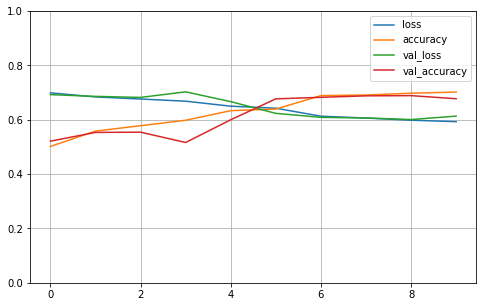

Compute valiation accuracy
2022-12-13 00:07:26.229263
Range of scores: 0.13321532 to 0.8653028
Predicted zeros and ones 2137 4180
Accuracy: 67.72% Precision: 61.79% Recall: 85.39% F1: 71.70%
2022-12-13 00:07:39.530685
Fold 2
Training example
[167 155 106 ...   0   0   0]
Train sizes (24921, 3997) (24921, 1)
Valid sizes (6299, 3997) (6299, 1)
Train set ones/size 12133 / 24921
Valid set ones/size 3079 / 6299
BUILD MODEL
COMPILE
FIT
2022-12-13 00:07:46.971330
Epoch 1/10
779/779 [==============================] - 103s 127ms/step - loss: 0.6898 - accuracy: 0.5494 - val_loss: 0.6903 - val_accuracy: 0.5601
Epoch 2/10
779/779 [==============================] - 97s 125ms/step - loss: 0.6710 - accuracy: 0.5920 - val_loss: 0.6639 - val_accuracy: 0.6114
Epoch 3/10
779/779 [==============================] - 100s 128ms/step - loss: 0.6596 - accuracy: 0.6159 - val_loss: 0.6718 - val_accuracy: 0.5829
Epoch 4/10
779/779 [==============================] - 100s 129ms/step - loss: 0.6663 - accuracy: 0.597

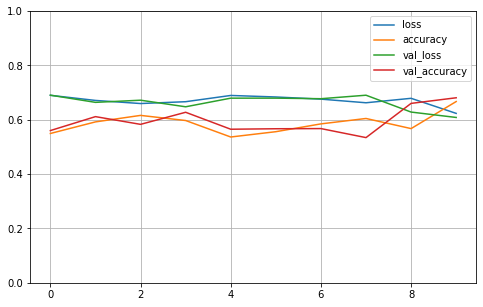

Compute valiation accuracy
2022-12-13 00:24:22.841581
Range of scores: 0.20288248 to 0.7278306
Predicted zeros and ones 2563 3736
Accuracy: 68.07% Precision: 64.29% Recall: 78.01% F1: 70.49%
2022-12-13 00:24:35.693621
Fold 3
Training example
[167 155 106 ...   0   0   0]
Train sizes (24914, 3997) (24914, 1)
Valid sizes (6306, 3997) (6306, 1)
Train set ones/size 12233 / 24914
Valid set ones/size 2979 / 6306
BUILD MODEL
COMPILE
FIT
2022-12-13 00:24:43.189883
Epoch 1/10
779/779 [==============================] - 104s 129ms/step - loss: 0.6959 - accuracy: 0.5081 - val_loss: 0.6909 - val_accuracy: 0.5276
Epoch 2/10
779/779 [==============================] - 100s 129ms/step - loss: 0.6777 - accuracy: 0.5682 - val_loss: 0.6790 - val_accuracy: 0.5745
Epoch 3/10
779/779 [==============================] - 99s 127ms/step - loss: 0.6681 - accuracy: 0.5954 - val_loss: 0.6847 - val_accuracy: 0.5347
Epoch 4/10
779/779 [==============================] - 99s 127ms/step - loss: 0.6778 - accuracy: 0.5849

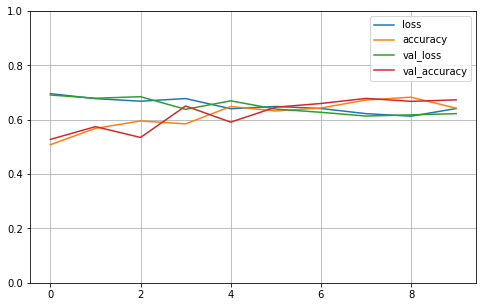

Compute valiation accuracy
2022-12-13 00:41:28.611250
Range of scores: 0.16152225 to 0.74895227
Predicted zeros and ones 3524 2782
Accuracy: 67.32% Precision: 66.50% Recall: 62.10% F1: 64.22%
2022-12-13 00:41:50.297479
Fold 4
Training example
[167 155 106 ...   0   0   0]
Train sizes (24986, 3997) (24986, 1)
Valid sizes (6234, 3997) (6234, 1)
Train set ones/size 12223 / 24986
Valid set ones/size 2989 / 6234
BUILD MODEL
COMPILE
FIT
2022-12-13 00:41:58.450879
Epoch 1/10
781/781 [==============================] - 107s 131ms/step - loss: 0.6946 - accuracy: 0.5170 - val_loss: 0.7084 - val_accuracy: 0.5205
Epoch 2/10
781/781 [==============================] - 98s 126ms/step - loss: 0.6919 - accuracy: 0.5181 - val_loss: 0.6886 - val_accuracy: 0.5205
Epoch 3/10
781/781 [==============================] - 103s 132ms/step - loss: 0.6821 - accuracy: 0.5614 - val_loss: 0.6719 - val_accuracy: 0.5852
Epoch 4/10
781/781 [==============================] - 100s 128ms/step - loss: 0.6802 - accuracy: 0.55

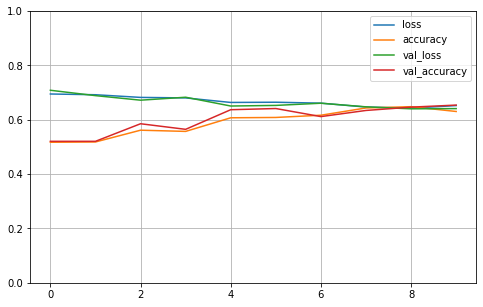

Compute valiation accuracy
2022-12-13 00:59:04.242074
Range of scores: 0.15120336 to 0.6219994
Predicted zeros and ones 3957 2277
Accuracy: 65.38% Precision: 68.25% Recall: 51.99% F1: 59.02%
2022-12-13 00:59:15.878970
Fold 5
Training example
[160 126 247 ...   0   0   0]
Train sizes (25156, 3997) (25156, 1)
Valid sizes (6064, 3997) (6064, 1)
Train set ones/size 12072 / 25156
Valid set ones/size 3140 / 6064
BUILD MODEL
COMPILE
FIT
2022-12-13 00:59:23.448495
Epoch 1/10
787/787 [==============================] - 105s 129ms/step - loss: 0.6934 - accuracy: 0.5250 - val_loss: 0.6670 - val_accuracy: 0.5968
Epoch 2/10
787/787 [==============================] - 100s 127ms/step - loss: 0.6769 - accuracy: 0.5801 - val_loss: 0.6823 - val_accuracy: 0.5665
Epoch 3/10
787/787 [==============================] - 99s 125ms/step - loss: 0.6825 - accuracy: 0.5617 - val_loss: 0.6632 - val_accuracy: 0.6097
Epoch 4/10
787/787 [==============================] - 100s 128ms/step - loss: 0.6623 - accuracy: 0.612

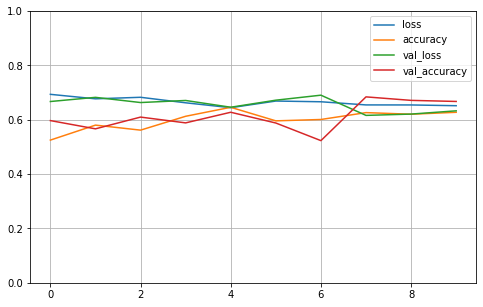

Compute valiation accuracy
2022-12-13 01:16:11.707835
Range of scores: 0.15098134 to 0.835706
Predicted zeros and ones 3606 2458
Accuracy: 66.72% Precision: 72.82% Recall: 57.01% F1: 63.95%
2022-12-13 01:16:24.349646

Cross validation 5 folds 10 epochs
 accuracy mean 67.04% +/- 0.94
 precision mean 66.73% +/- 3.74
 recall mean 66.90% +/- 12.72
 F1 mean 65.88% +/- 4.66
2022-12-13 01:16:24.353623


In [97]:
print(datetime.now())
cv_accuracy, cv_precision, cv_recall, cv_f1 = do_cross_validation(EPOCHS)   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))

print(datetime.now())

Results on CoLab
Coding, len 1000-2000, 4 cells, break after 1 fold, 5 epochs.   
Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
rnn1_layer = LSTM(RCELLS, return_sequences=False) # True)
output_layer = Dense(1,activation='sigmoid',dtype=dt)
1. K=4, accuracy: 0.6608, val_accuracy: 0.6190
1. K=1, accuracy: 0.6329, val_accuracy: 0.6167 

Next try mask_zero=False, return_sequences=True
1. K=4,  accuracy: 0.6441, val_accuracy: 0.6258
1. K=1, accuracy: 0.5756, val_accuracy: 0.5896